#### Data Generating Process

In [72]:
rm(list=ls())

library(glmnet)
library(mvtnorm)

set.seed(70)
n    <- 10000    
p    <- 200
s    <- 5
rho  <- 0.5

beta   <- c(round(runif(s, -2, 4), 1), 
            rnorm(((p/2) - s), 0, 1),
            rep(0, p + 1 - p/2))


corr_matrix <- matrix(NA, p, p)

for (i in 1:p) {
    for (j in 1:p) {
    corr_matrix[i, j] <- rho^(abs(i - j))
    }
}

X   <- cbind(rep(1, n), rmvnorm(n, rep(0,p), corr_matrix))
eps <- rnorm(n, 0, 1) 
Y   <- X %*% beta + eps
df  <- data.frame(Y, X)

X_train <- X[1:1000,]
Y_train <- Y[1:1000]
X_test  <- X[1001:n,]
Y_test  <- Y[1001:n]

#### Setup Simulation Function 

In [73]:
sim_function <- function(n_sample){
    
    set.seed(i)
    index    <- sample(nrow(X_train), size = n_sample)
    X_sample <- X_train[index,]
    Y_sample <- Y_train[index]

    K             <- c(nrow(X_sample), 10, 5)
    fun.matrix    <- matrix(NA, nrow = 3, ncol = 3)
    
    for (k in 1:length(K)) {
    lasso_model        <- suppressWarnings(cv.glmnet(X_sample, Y_sample, nfolds = K[k], type.measure = "mae", alpha=1)) 
    fun.matrix[k,1]    <- lasso_model$cvm[lasso_model$lambda == lasso_model$lambda.min]
        
    Y_pred            <- predict(lasso_model, s=lasso_model$lambda.min, newx=X_test)
    fun.matrix[k,2]   <- mean(abs(Y_pred - Y_test))      # use mse or mae?
        
    fun.matrix[k,3]   <- lasso_model$lambda.min
    }     
    
    return(fun.matrix)
}

#### Simulation

In [ ]:
# Varying the Sample Size from 30 to 150
sample_size <- seq(30, 200, by = 10)
sim         <- length(sample_size)

# Number of iterations to perform over each sample size.
rep = 50

# Create matrices to store error repetitions and bias/variance for each sample size. 
test_mse.matrix <- matrix(NA, ncol = 3, nrow = rep)
true_mse.matrix <- matrix(NA, ncol = 3, nrow = rep)
lambda.matrix   <- matrix(NA, ncol = 3, nrow = rep)

error.matrix <- matrix(NA, ncol = 3, nrow = sim)
bias_matrix  <- matrix(NA, ncol = 3, nrow = sim)
var_matrix   <- matrix(NA, ncol = 3, nrow = sim)

# for Loop gives us realizations of the 4 errors FOR each iteration, FOR each increasing sample size.
for (j in 1:sim) {
    for (i in 1:rep) {
        funct.matrix          <- sim_function(sample_size[j])
        test_mse.matrix[i, 1] <- funct.matrix[1,1]  # Realization of MSE in the i'th iteration
        test_mse.matrix[i, 2] <- funct.matrix[2,1]
        test_mse.matrix[i, 3] <- funct.matrix[3,1]
        
        true_mse.matrix[i, 1] <- funct.matrix[1,2]  # Realization of MSE in the i'th iteration
        true_mse.matrix[i, 2] <- funct.matrix[2,2]
        true_mse.matrix[i, 3] <- funct.matrix[3,2]
        
        lambda.matrix[i, 1] <- funct.matrix[1,3]  # Realization of MSE in the i'th iteration
        lambda.matrix[i, 2] <- funct.matrix[2,3]
        lambda.matrix[i, 3] <- funct.matrix[3,3]     
        }

    error.matrix[j,1] <- mean(true_mse.matrix[,1])
    error.matrix[j,2] <- mean(true_mse.matrix[,2])
    error.matrix[j,3] <- mean(true_mse.matrix[,3])
    
    bias_matrix[j,1] <- mean((test_mse.matrix[,1] - true_mse.matrix[,1]))  # Realization of bias for j'th sample size
    bias_matrix[j,2] <- mean((test_mse.matrix[,2] - true_mse.matrix[,2]))
    bias_matrix[j,3] <- mean((test_mse.matrix[,3] - true_mse.matrix[,3]))
    
    var_matrix[j,1] <- var((test_mse.matrix[,1] - true_mse.matrix[,1]))  # Realization of bias for j'th sample size
    var_matrix[j,2] <- var((test_mse.matrix[,2] - true_mse.matrix[,2]))
    var_matrix[j,3] <- var((test_mse.matrix[,3] - true_mse.matrix[,3]))
    
}


#### Plotting the Results

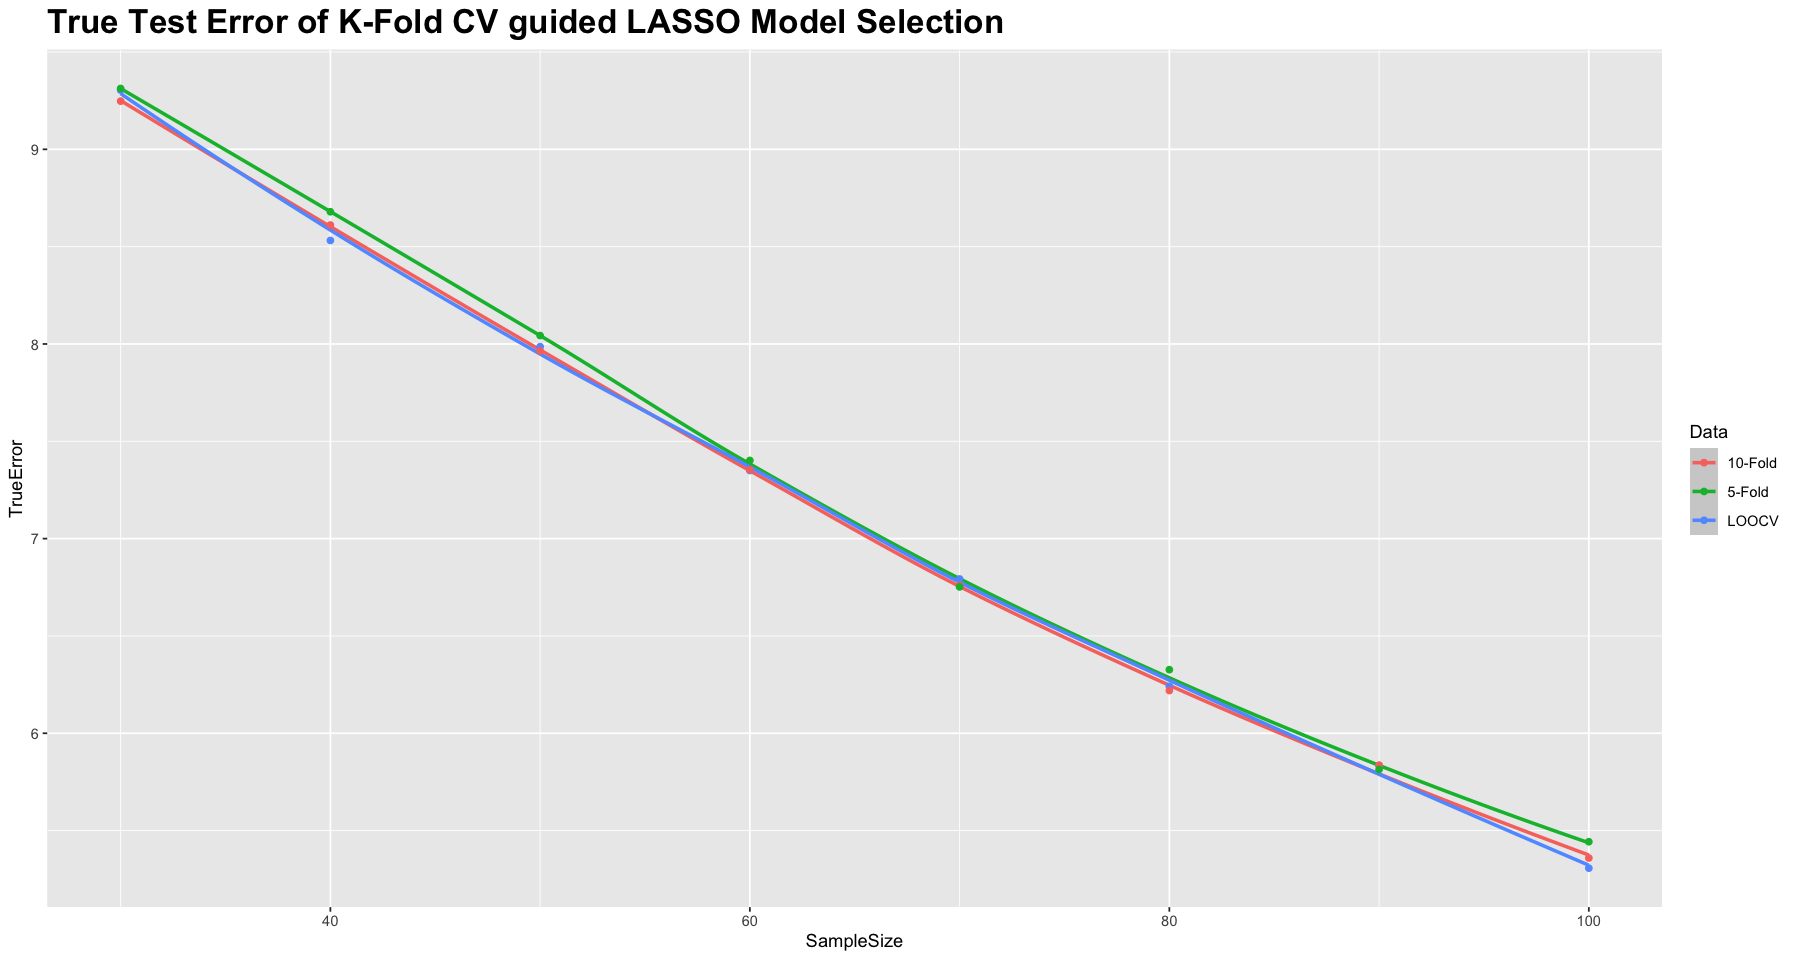

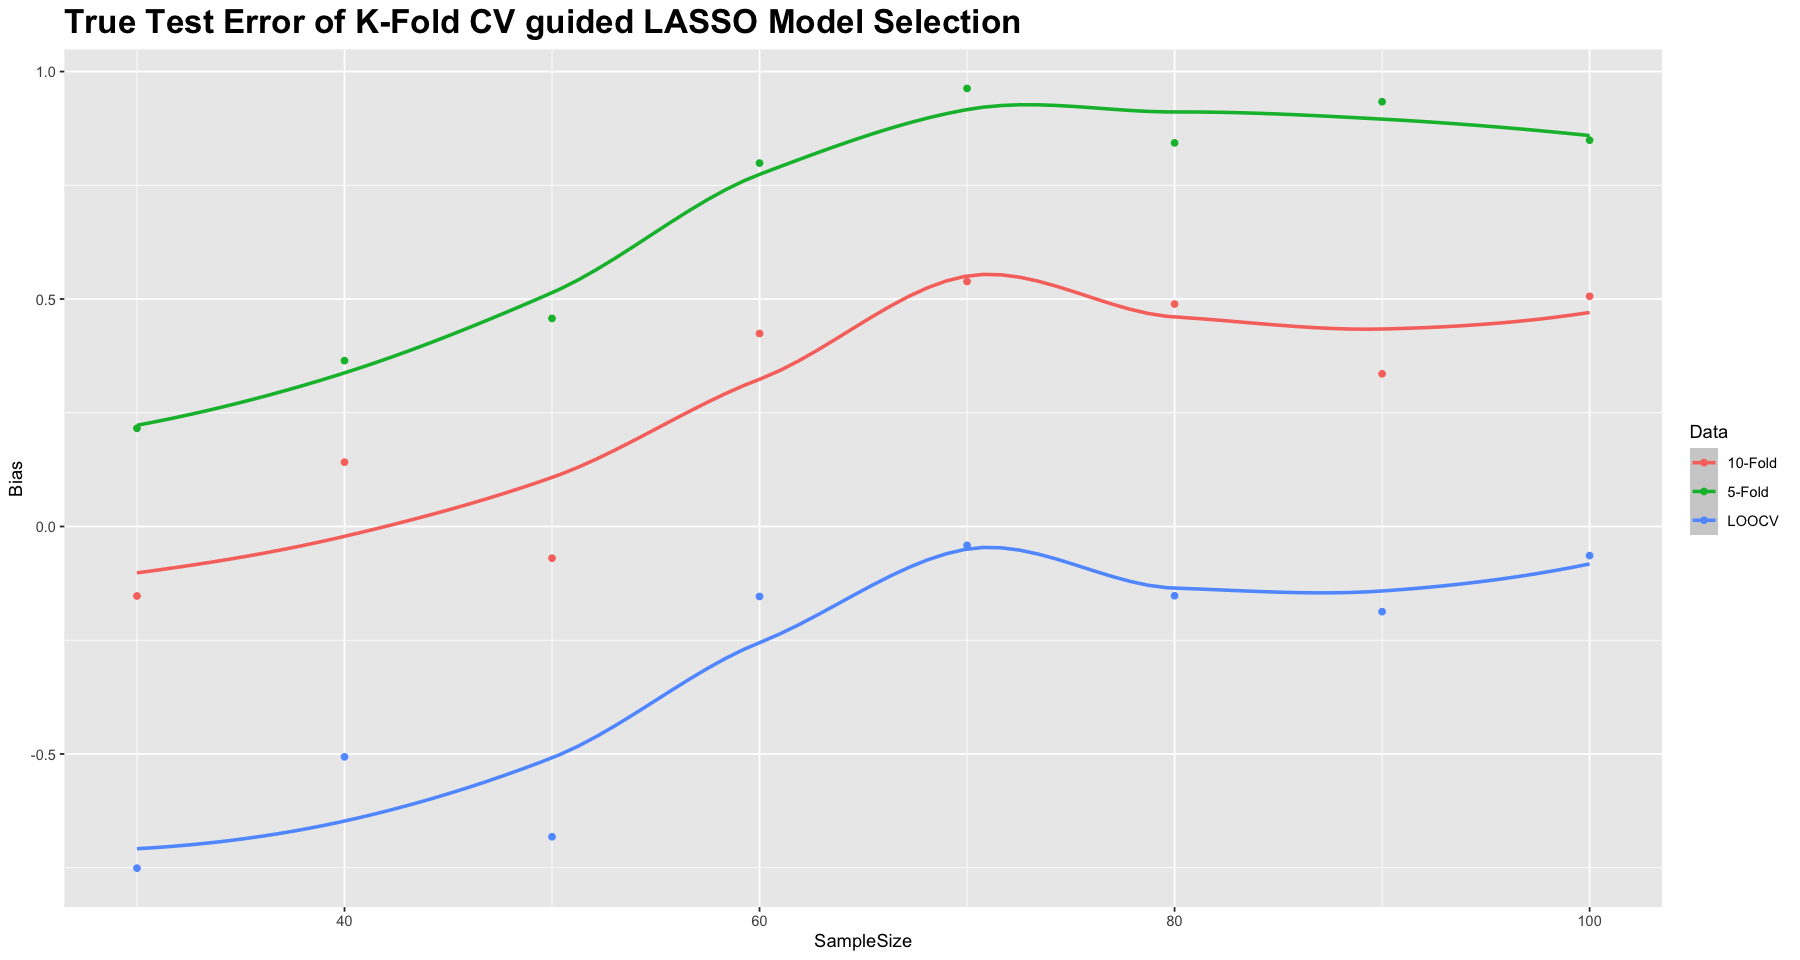

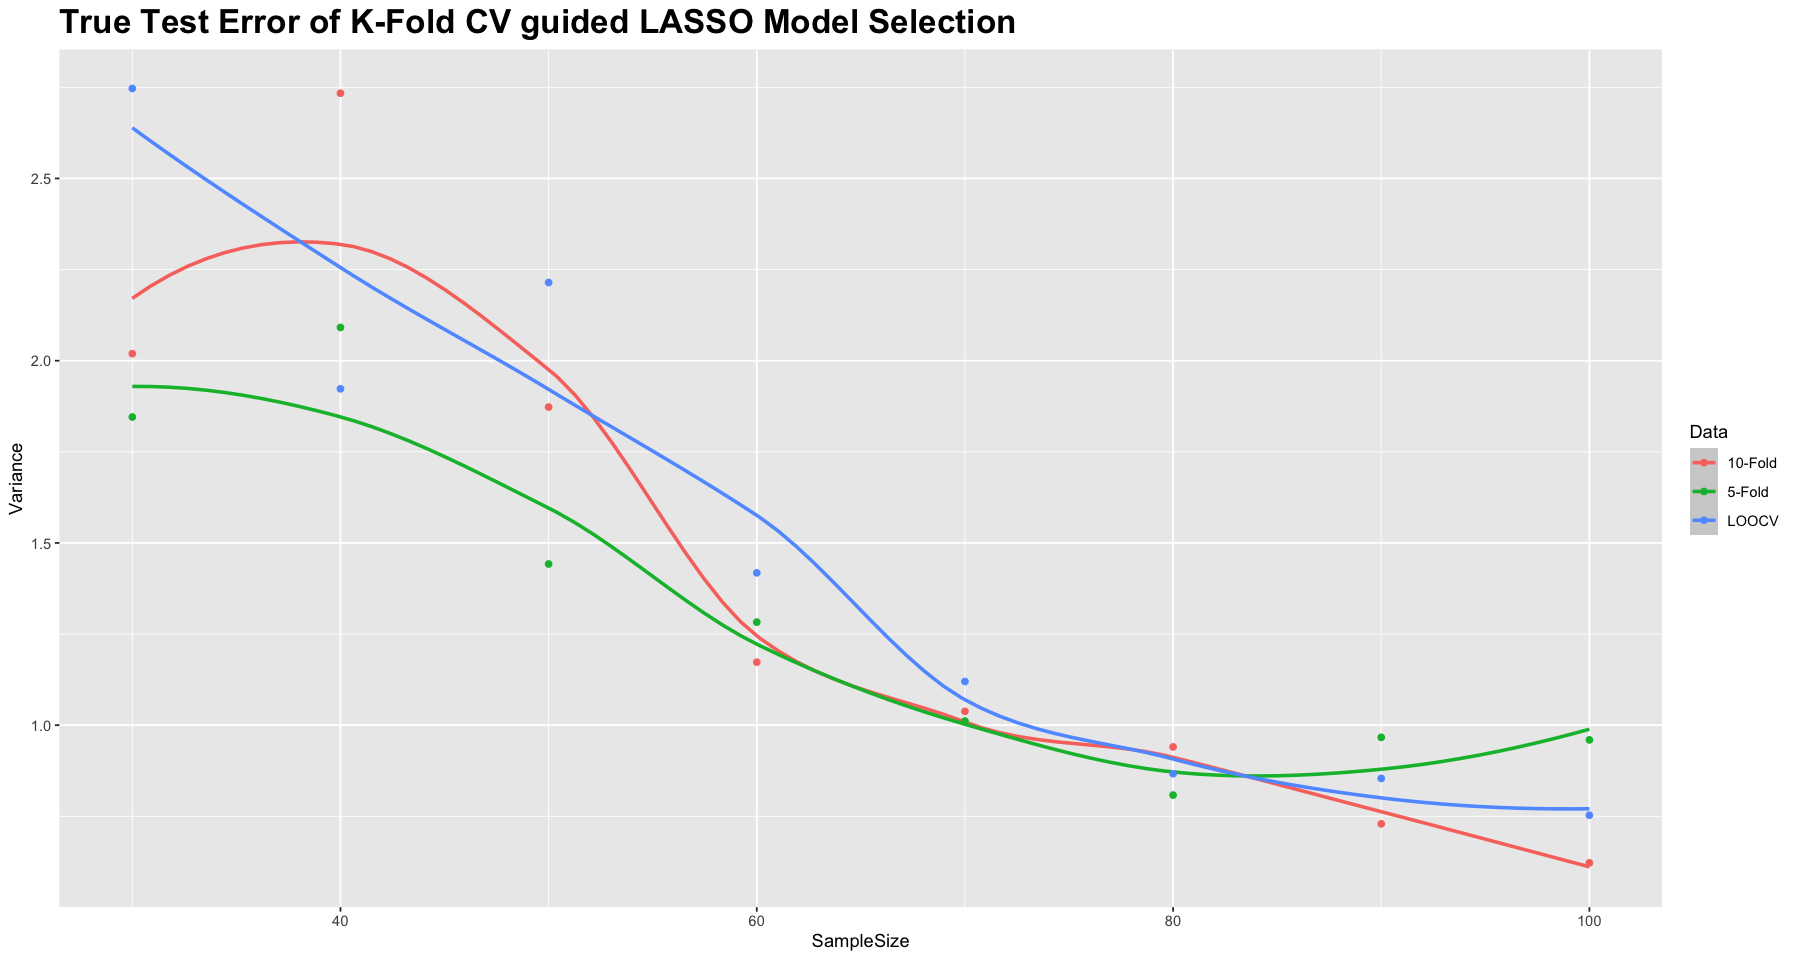

In [75]:
library(ggplot2)
# All the result are organized in a trade-off matrix which will be used to plot graphs
df_true_error <- data.frame(c(rep("LOOCV",sim), rep("10-Fold",sim), rep("5-Fold",sim)),
    c(error.matrix[,1],error.matrix[,2], error.matrix[,3]),
    c(bias_matrix[,1],bias_matrix[,2], bias_matrix[,3]),
    c(var_matrix[,1],var_matrix[,2], var_matrix[,3]),           
    rep(sample_size,3))
colnames(df_true_error)<-c("Data","TrueError","Bias","Variance", "SampleSize")

df_errors <- data.frame(c(rep("True",rep),rep("LOOCV",rep), rep("5-Fold",rep), rep("10-Fold",rep)),
    rep(1:rep,4),c(error_matrix[,1],error_matrix[,2], error_matrix[,3], error_matrix[,4]))
colnames(df_errors)<-c("Data","Iteration","Error")

# Plot the Generalized Error against Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=TrueError, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("True Test Error of K-Fold CV guided LASSO Model Selection") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Bias against Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=Bias, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("True Test Error of K-Fold CV guided LASSO Model Selection") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Variance against Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=Variance, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("True Test Error of K-Fold CV guided LASSO Model Selection") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

In [66]:
true_mse.matrix
test_mse.matrix

59.67786,58.11018,58.55316
37.68235,37.68235,44.35213
41.10453,41.10453,40.79452
43.07013,52.35731,54.14323
69.43549,69.35887,66.70497
29.05756,30.43742,28.28322
51.40188,49.73110,52.23433
38.40806,38.58690,38.42018
49.97771,49.97771,50.48773
57.56867,57.03271,60.82101
51.32880,51.23059,50.27305


43.94062,49.51795,57.38492
39.46955,56.55151,68.73126
57.36081,58.27973,61.32314
39.30705,59.59249,75.03274
34.86800,37.38323,56.70277
42.10243,58.22691,68.71219
46.22621,59.14487,70.68859
25.28768,36.08688,37.53763
35.27006,57.52950,63.05833
62.87687,72.13530,95.58040
43.74835,57.35732,55.32085


In [ ]:
lasso_coef  <- predict(lasso_refit, type="coefficients", s=best_lam[2,1])[1:p+1,] 
lasso_coef
lasso_sparsity <- lasso_coef[lasso_coef!=0]
lasso_sparsity
beta_true
coef(lasso_model, s = "lambda.min")

In [ ]:
my_data <- read.csv("/Users/DanialSyed/Documents/BGSE/Adv Modules/Computational Statistics/Project/2020-12.csv")